In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# -----------------------------------------------------------------------------------------------
# начальные значения
v0 = 2500                               # начальная скорость БЦ, м/с
theta = 30                              # угол между начальной скоростью и плоскостью xy
phi = 20                                # угол между проекцией начальной скорости на плоскость xy и осью x
geo_width = 55                          # геодезическая широта (тк нам не дано местоположение объекта)
geo_longitude = 60                      # геодезическая долгота
gamma = 1e-4                            # баллистический коэффициент
# -----------------------------------------------------------------------------------------------
# константы
a = 6378245                             # большая полуось Земли
b = 6356863                             # малая полуось Земли

GM = 3.986004418e14                     # произведение гравитационной постоянной Земли на массу
c_0 = 2.202095e10                       # коэффициент гравитационного поля Земли
omega = 7.292115e-5                     # угловая скорость вращения Земли
f = 298.3                               # коэффициент сжатия Земли
e_squared = (2*f-1)/((f - 1)**2)        # квадрат эксцентриситета Земли
# -----------------------------------------------------------------------------------------------
r = a/np.sqrt(1+(1/(1-1/f)**2 - 1)      # расстояние от начала ГПСК до начала МЗСК
  *(np.sin(np.radians(geo_width)))**2)    
H = 1                                   # высота объекта над поверхностью эллипсоида
# ------------------------------------------------------------------------------------
# Формулы для пересчета из ГПСК в МЗСК
# ------------------------------------------------------------------------------------
sin_geo_width = np.sin(np.radians(geo_width))                                        
cos_geo_width = np.cos(np.radians(geo_width))
sin_geo_longitude = np.sin(np.radians(geo_longitude))
cos_geo_longitude = np.cos(np.radians(geo_longitude))

# матрица направляющих косинусов 
A_mg = np.array([[-cos_geo_longitude*sin_geo_width, -sin_geo_longitude*sin_geo_width, cos_geo_width], 
                 [cos_geo_longitude*cos_geo_width, sin_geo_longitude*cos_geo_width, sin_geo_width], 
                 [sin_geo_longitude, cos_geo_longitude, 0]])

# геоцентрическая широта начала координат МЗСК
geocentric_latitude = np.arctan((1-1/f)**2 * np.radians(np.tan(np.radians(geo_width))))

sin_geocentric_latitude = np.sin(np.radians(geocentric_latitude))
cos_geocentric_latitude = np.cos(np.radians(geocentric_latitude))

# координаты центра МЗСК в ГПСК
x_0 = np.array([r*cos_geocentric_latitude*cos_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                r*cos_geocentric_latitude*sin_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                r*sin_geocentric_latitude + H*sin_geo_width])

In [170]:
def equations(coordinate, speed):
    """
    Calculate the acceleration using formulas.
    
    Args:
        coordinate (numpy.ndarray): The coordinate of the ballistic target at each moment of time.
        speeds (numpy.ndarray): The speed of a ballistic target at each moment time.
    
    Returns:
        numpy.ndarray: Calculate the acceleration using formulas.
    """
    x, y, z = coordinate
    vx, vy, vz = speed
    
    # вычисление первых производных 
    dx_dt = vx
    dy_dt = vy
    dz_dt = vz
    
    # учет ускорения свободного падения g_0
    r_0 = np.sqrt(x**2 + y**2 + z**2)
    A = GM/r_0**3
    B = (3*c_0)/r_0**2
    C = (15*c_0)/r_0**4
    D = (6*c_0)/r_0**2
    
    dvx_dt = -A*x + A*B*x - A*C*x*z**2
    dvy_dt = -A*y + A*B*y - A*C*y*z**2
    dvz_dt = -A*z + A*B*z + A*D*z - A*C*z**3
    
    # учет центростремительного ускорения БЦ
    dvx_dt += omega**2 * x
    dvy_dt += omega**2 * y
    dvz_dt += 0
    
    # учет кориолисова ускорения
    dvx_dt += 2 * omega * dy_dt
    dvy_dt += -2 * omega * dx_dt
    dvz_dt += 0
    
    # учет аэродинамического ускорения 
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    s = z/r_0                                     # синус широты цели
    h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
    
    rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 
               + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
    E = (-gamma * rho * v)/2
    
    dvx_dt += E * dx_dt
    dvy_dt += E * dy_dt
    dvz_dt += E * dz_dt
    
    return np.array([dx_dt, dy_dt, dz_dt, dvx_dt, dvy_dt, dvz_dt])

In [171]:
def runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed):
    """
    To lower the degree of a system of differential equations by the Runge-Kutta method of 4 orders.
    
    Args:
        t0 (int): The start time of the movement of the ballistic target.
        t_end (int): The final time when a ballistic target falls to the surface.
        dt (int): A step in the Runge-Kutta method.
        intial_coordinate (numpy.ndarray): Array of initial values of x, y, z in MHSK.
        intial_speed (numpy.ndarray): Array of initial speeds of vx, vy, vz in MHSK.
        
    Returns:
        list: A list of coordinates and speeds.
    """
    t = t0
    coordinates = [initial_coordinate]
    speeds = [initial_speed]
    
    while t < t_end:
        coordinate = coordinates[-1]
        speed = speeds[-1]
        
        
        k1 = equations(coordinate, speed)
        q1 = speed
        k2 = equations(coordinate + dt/2 * q1, speed + dt/2 * k1[-3:])
        q2 = q1 + k1[-3:] * dt/2
        k3 = equations(coordinate + dt/2 * q2, speed + dt/2 * k2[-3:])
        q3 = q1 + k2[-3:] * dt/2
        k4 = equations(coordinate + dt * q3, speed + dt * k3[-3:])
        q4 = q1 + k3[-3:] * dt                             
        
        new_coordinate = coordinate + dt/6 * (q1 + 2*q2 + 2*q3 + q4)
        coordinates.append(new_coordinate)
        
        new_speed = speed + dt/6 * (k1[-3:] + 2*k2[-3:] + 2*k3[-3:] + k4[-3:])
        speeds.append(new_speed)

        t += dt 
        
    return [np.array(coordinates), np.array(speeds)]

In [172]:
# -------------------------------------------------------------------------------------
t0 = 0                      # initial moment of time
t_end = 30                  # end point in time
dt = 1                      # step for the runge kutta method
# -------------------------------------------------------------------------------------
def get_result():
    """
    The main function for obtaining coordinates and their first derivatives.
    
    Returns:
        list: A list of coordinates, speeds, (in the GPSK coordinate system) and the flight time column of a ballistic target.
    """
    initial_coordinate = np.array([x_0[0], x_0[1], x_0[2]])
    initial_speed = np.array([v0 * np.sin(np.radians(theta)) * np.cos(np.radians(phi)), 
                              v0 * np.sin(np.radians(theta)) * np.sin(np.radians(phi)), 
                              v0 * np.cos(np.radians(theta))])

    result = runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed)
    
    coordinate = result[0]
    speed = result[1]

    # Extracting coordinates and time from the result.
    x = coordinate[:, 0]
    y = coordinate[:, 1]
    z = coordinate[:, 2]
    vx = speed[:, 0]
    vy = speed[:, 1]
    vz = speed[:, 2]
    t = np.arange(t0, t_end + dt, dt)
    t_list = t.tolist()
    
    return [x, y, z, vx, vy, vz, t_list] 

In [173]:
def recalculation_GPSK_MZSK(result):
    """
    Translation of coordinates from GPSK to MHSK.
    """       
    iterations = len(result[0])
    
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []
    xyz = []
    vx_vy_vz = []
    
    # Formation of a list of coordinates and a list of speeds transferred to the MHSK.
    for i in range(iterations):
        
        coordinates_g = np.array([result[0][i], result[1][i], result[2][i]])
        coordinates_m = np.dot(A_mg, coordinates_g - x_0) 
        
        xyz.append(coordinates_m.tolist())
        x.append(xyz[i][0])
        y.append(xyz[i][1])
        z.append(xyz[i][2])     
        
        speeds_g = np.array([result[3][i], result[4][i], result[5][i]])
        speeds_m = np.dot(A_mg, speeds_g)
        
        if(i == 0):
            vx_vy_vz.append(speeds_g.tolist())
        else:
            vx_vy_vz.append(speeds_m.tolist())
        
        vx.append(vx_vy_vz[i][0])
        vy.append(vx_vy_vz[i][1])
        vz.append(vx_vy_vz[i][2])
        
        i += 1 
            
    return np.array([x, y, z, vx, vy, vz])


In [174]:
# -------------------------------------------------------------------------------------
# Выделение из ответа координат и скоростей для последующих расчетов
# -------------------------------------------------------------------------------------
result = recalculation_GPSK_MZSK(get_result())
x = result[0]
y = result[1]
z = result[2]

vx = result[3]
vy = result[4]
vz = result[5]

t = np.array(get_result()[6])
# -------------------------------------------------------------------------------------
# Вычисление скорости и дальности в МЗСК 
# -------------------------------------------------------------------------------------
v = np.sqrt(vx**2 + vy**2 + vz**2) 
L = np.sqrt(x**2 + y**2) 
# -------------------------------------------------------------------------------------
# Составление таблицы с основными данными
# -------------------------------------------------------------------------------------
result_data = pd.DataFrame()

result_data['t'] = t.astype(int)
result_data['x'] = x.astype(int)
result_data['y'] = y.astype(int)
result_data['z'] = z.astype(int)
result_data['L'] = L.astype(int)

result_data
# -------------------------------------------------------------------------------------
# Все расчеты проводятся в системе ГПСК(Гринвичская прямоугольная система координат). 
# Начало ГПСК находится в центре Земли.
# Далее полученные координаты и скорости переводятся в МЗСК - местная земная система координат
# -------------------------------------------------------------------------------------

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

,t,x,y,z,L
0,0,0,0,0,0
1,1,458,2307,1220,2352
2,2,919,4575,2414,4667
3,3,1378,6793,3576,6932
4,4,1833,8947,4699,9133
5,5,2281,11023,5776,11256
6,6,2719,13010,6801,13291
7,7,3144,14899,7770,15227
8,8,3556,16685,8681,17059
9,9,3952,18366,9534,18787


In [175]:
# -------------------------------------------------------------------------------------
# Обрежем данные для графиков
# -------------------------------------------------------------------------------------
t_cut = np.where(z >= 0, t, np.nan)
z_cut = np.where(z >= 0, z, np.nan)
L_cut = np.where(z >= 0, L, np.nan)

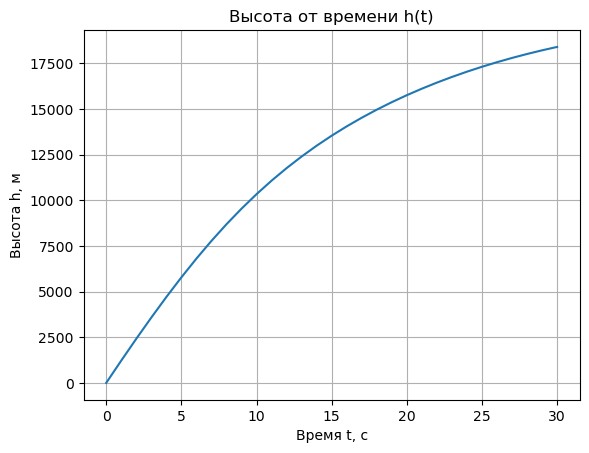

In [176]:
# -------------------------------------------------------------------------------------
# Визуализация высоты от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t_cut, z_cut)
plt.xlabel('Время t, с')
plt.ylabel('Высота h, м')
plt.title('Высота от времени h(t)')
plt.grid(True)

plt.show()


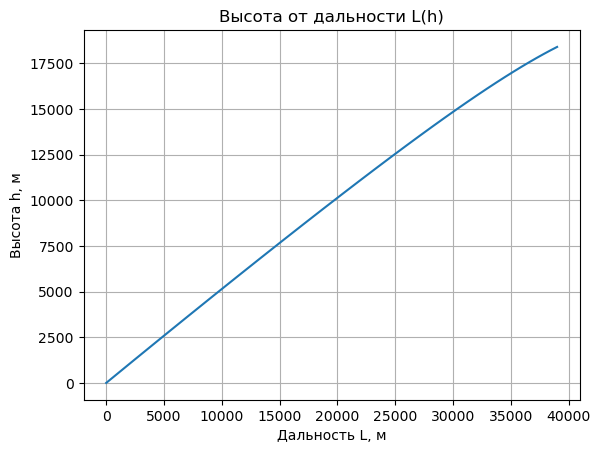

In [177]:
# -------------------------------------------------------------------------------------
# Визуализация высоты от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L_cut, z_cut)
plt.xlabel('Дальность L, м')
plt.ylabel('Высота h, м')
plt.title('Высота от дальности L(h)')
plt.grid(True)

plt.show()

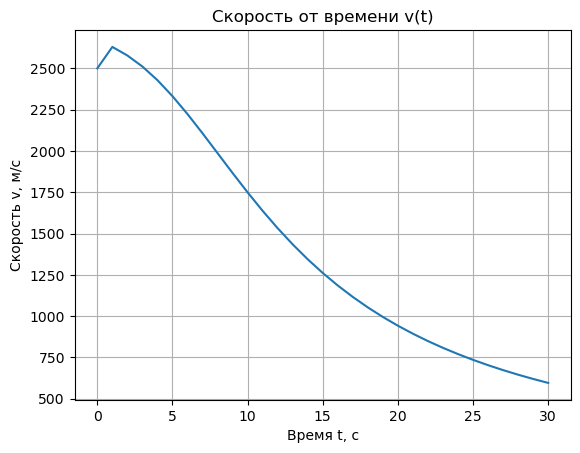

In [178]:
# -------------------------------------------------------------------------------------
# Визуализация скорости от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t_cut, v)
plt.xlabel('Время t, с')
plt.ylabel('Скорость v, м/c')
plt.title('Скорость от времени v(t)')
plt.grid(True)

plt.show()

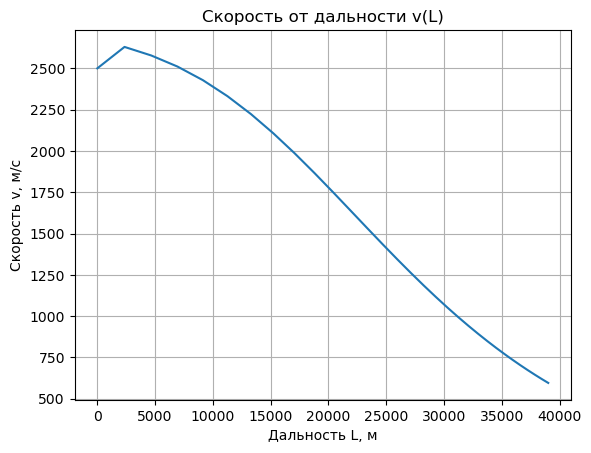

,t,vx,vy,vz,v,L
0,0,1174,427,2165,2500,0
1,1,460,2289,1208,2629,2352
2,2,460,2245,1179,2577,4667
3,3,457,2187,1143,2510,6932
4,4,452,2116,1100,2428,9133
5,5,443,2033,1051,2331,11256
6,6,431,1939,997,2223,13291
7,7,418,1838,940,2106,15227
8,8,403,1733,881,1986,17059
9,9,388,1629,823,1866,18787


In [179]:
# -------------------------------------------------------------------------------------
# Визуализация скорости от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L, v)
plt.xlabel('Дальность L, м')
plt.ylabel('Скорость v, м/с')
plt.title('Скорость от дальности v(L)')
plt.grid(True)

plt.show()

# -------------------------------------------------------------------------------------
# Таблица скорости от дальности
# -------------------------------------------------------------------------------------
data = pd.DataFrame()
data['t'] = t
data['vx'] = list(map(int, vx))
data['vy'] = list(map(int, vy))
data['vz'] = list(map(int, vz))
data['v'] = list(map(int, v))
data['L'] = list(map(int, L))
data

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

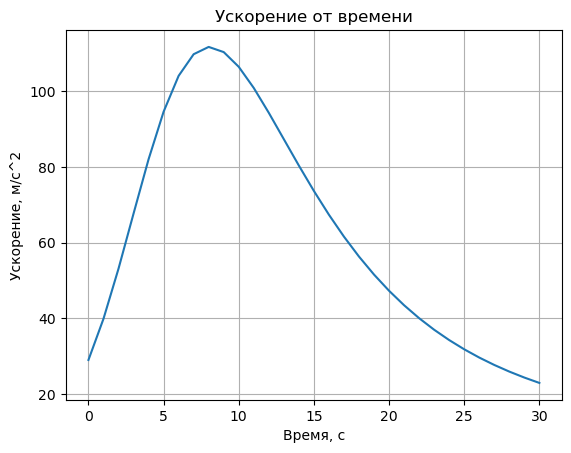

,g,L
0,29,0
1,39,2352
2,53,4667
3,67,6932
4,81,9133
5,94,11256
6,104,13291
7,109,15227
8,111,17059
9,110,18787


In [180]:
# -------------------------------------------------------------------------------------
# Нахождение ускорения: вычисленные координаты подставляю в систему уравнения: 
# dx/dt = x'
# dx'/dt = g
# -------------------------------------------------------------------------------------
state_g = get_result()
x_g = state_g[0]
y_g = state_g[1]
z_g = state_g[2]

vx_g = state_g[3]
vy_g = state_g[4]
vz_g = state_g[5]

v_g = np.sqrt(vx_g**2 + vy_g**2 + vz_g**2)
r_0 = np.sqrt(x_g**2 + y_g**2 + z_g**2)

A = GM/r_0**3
B = (3*c_0)/r_0**2
C = (15*c_0)/r_0**4
D = (6*c_0)/r_0**2

s = z_g/r_0                                     # синус широты цели
h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли

rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 
            + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
E = (-gamma * rho * v_g)/2

g_0x = -A*x_g + A*B*x_g - A*C*x_g*z_g**2
g_0y = -A*y_g + A*B*y_g - A*C*y_g*z_g**2
g_0z = -A*z_g + A*B*z_g + A*D*z_g - A*C*z_g**3

g_cax = omega**2 * x_g
g_cay = omega**2 * y_g

g_corx = 2 * omega * vy_g
g_cory = - 2 * omega * vx_g

g_aerx = E * vx_g
g_aery = E * vy_g
g_aerz = E * vz_g

g_x =  g_0x + g_cax + g_corx + g_aerx
g_y =  g_0y + g_cay + g_cory + g_aery
g_z =  g_0z + g_aerz
    
g = np.sqrt(g_x**2 + g_y**2 + g_z**2)
# -------------------------------------------------------------------------------------
# Обработка случая столкновения с поверхностью
# -------------------------------------------------------------------------------------
# g[zero_index_z : length + 1] = g[zero_index_z - 1]
# -------------------------------------------------------------------------------------
# Таблица ускорение, время, дальность
# -------------------------------------------------------------------------------------
acceleration = pd.DataFrame()
acceleration['g'] = list(map(int, g))

acceleration['L'] = list(map(int, L))
# -------------------------------------------------------------------------------------
# Визуализация ускорения от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t_cut, g)
plt.xlabel('Время, c')
plt.ylabel('Ускорение, м/c^2')
plt.title('Ускорение от времени')
plt.grid(True)

plt.show()
acceleration

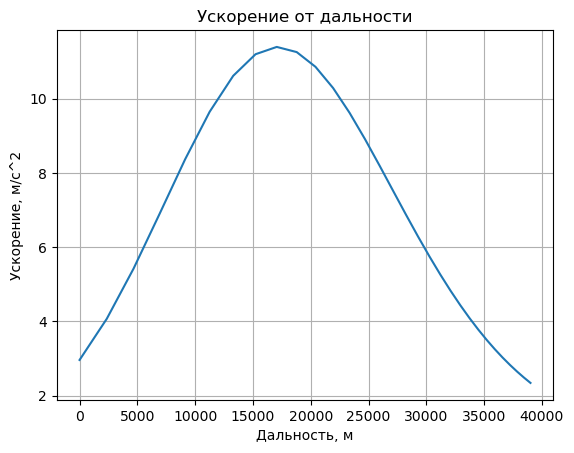

In [181]:
# -------------------------------------------------------------------------------------
# Визуализация ускорения от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L, g/9.8)
plt.xlabel('Дальность, м')
plt.ylabel('Ускорение, м/c^2')
plt.title('Ускорение от дальности')
plt.grid(True)

plt.show()

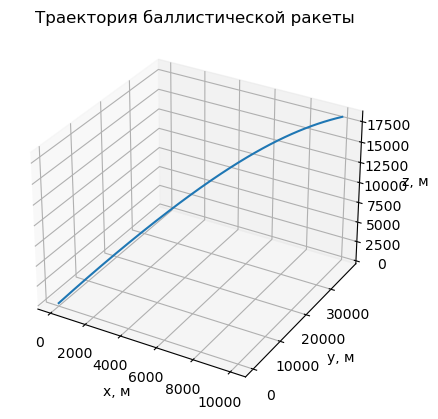

In [182]:
# -------------------------------------------------------------------------------------
# Визуализация траектории ракеты в 3D
# -------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('x, м')
ax.set_ylabel('y, м')
ax.set_zlabel('z, м')
ax.set_title('Траектория баллистической ракеты')

plt.show()